In [1]:
import iris
import iris.coord_categorisation
import cf_units
import calendar
import numpy as np
import cartopy.util
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pathlib import Path
from copy import copy
plt.rcParams['mathtext.default'] = 'regular'

In [2]:
from util_mypaths import path_to_raw

#### Process data

In [3]:
# Read data
path_to_gfed = Path.cwd().parent.parent.parent / 'obs' /'GFEDs'
path_to_ukca = Path.cwd().parent / 'processed'
gfed = iris.load(str(path_to_gfed / 'GFED4.1s_1997-2016_multiyear_monthly_mean_dm_emissions.nc'))
ukca = iris.load_cube(str(path_to_ukca / 'xojng' / 'xojng_o3.nc'))
# Path to figures
path_to_figs = Path.cwd().parent.parent.parent / 'results' / 'rono2_emis'
publish = True
if publish:
    mpl.rcParams['xtick.labelsize'] = 12
    mpl.rcParams['ytick.labelsize'] = 12
    mpl.rcParams['axes.titlesize'] = 12
    mpl.rcParams['axes.labelsize'] = 12
    plt.rcParams['font.size'] = 12

From Akagi et al. (2011) Table 1 Emission factors (g kg-1) for species emitted from different types of biomass burning. Emission factors are shown with an estimate of the natural variation in parenthesis, when available. Note that boreal and extratropical forest values are the same for C1-C3 RONO2.

| RONO2   | tropical forest       | savannah            | crop residue | pasture maintenance | boreal forest | temperate forest | extratropical forest |
|---------|-----------------------|---------------------|--------------|---------------------|---------------|------------------|----------------------|
| MeONO2  | 8.29×10−3 (1.60×10−2) | 5.1×10−4 (3.7×10−4) | -            | -                   | 2.83×10−3     | -                | 2.83×10−3            |
| EtONO2  | 5.70×10−3             | 3.51×10-4*          | -            | -                   | 1.78×10−3     | -                | 1.78×10−3            |
| nPrONO2 | 3.00×10-4             | 1.85×10-5*          | -            | -                   | 3.23×10−4     | -                | 3.23×10−4            |
| iPrONO2 | 1.00×10-3             | 6.15×10-5*          | -            | -                   | 3.23×10−3     | -                | 3.23×10−3            |
* calculated in this work

From Akagi et al. (2011): 'We split the category “extratropical forest” used by Andreae and Merlet (2001) into “boreal” (high latitude ∼50–70◦ forested regions) and “temperate” forest. We also derive EF for “extratropical” forest fires using a weighted average of boreal and temperate emission factors (86.5% and 13.5%, respectively) based on GFED3 biomass consumption estimates (van der Werf et al., 2010) to preserve the option of using this category'.

In [4]:
gfed

Fractional Contribution Of Peatland Fires To Dry Matter Emissions (1),time,latitude,longitude
Shape,12,720,1440
Dimension coordinates,,,
time,x,-,-
latitude,-,x,-
longitude,-,-,x
Fractional Contribution Of Agricultural Waste Burning To Dry Matter Emissions (1),time,latitude,longitude
Shape,12,720,1440
Dimension coordinates,,,
time,x,-,-
latitude,-,x,-


In [5]:
# Extract GFED dry matter emissions, GFED grid cell area, GFED and UKCA coordinates
dm = gfed.extract_strict('dry matter emissions')
dm_fr_borf = gfed.extract_strict('fractional contribution of boreal forest fires to dry matter emissions')
dm_fr_temf = gfed.extract_strict('fractional contribution of temperate forest fires to dry matter emissions')
dm_fr_sava = gfed.extract_strict('fractional contribution of savanna, grassland and shrubland fires to dry matter emissions')
dm_fr_trof = gfed.extract_strict('fractional contribution of tropical forest fires to dry matter emissions')
gfed_grid_cell_area = gfed.extract_strict('grid cell area')
gfed_lats = dm.coord('latitude').points
gfed_lons = dm.coord('longitude').points
ukca_lats = ukca.coord('latitude').points
ukca_lons = ukca.coord('longitude').points
# Restore time units. Note: in cf_units udunits.dat unit month is defined to be exactly year/12 (so all months have the same length as in 360_day calendar)
dm.coord('time').units = cf_units.Unit('month') 
dm_fr_borf.coord('time').units = cf_units.Unit('month')
dm_fr_temf.coord('time').units = cf_units.Unit('month')
dm_fr_sava.coord('time').units = cf_units.Unit('month')
dm_fr_trof.coord('time').units = cf_units.Unit('month')

From https://www.geo.vu.nl/~gwerf/GFED/GFED4/ancill/code/get_GFED4s_CO_emissions.py

```python
# calculate CO emissions as the product of DM emissions (kg DM per 
# m2 per month), the fraction the specific source contributes to 
# this (unitless), and the emission factor (g CO per kg DM burned)
CO_emissions += DM_emissions * contribution * EF_CO[source]
```

In [6]:
# Akagi et al. (2011) emission factors [g kg]
meono2_ef_trof = iris.coords.AuxCoord(8.29*1e-3, units='g/kg', long_name='methyl nitrate tropical forest fire emission factor')
meono2_ef_sava = iris.coords.AuxCoord(5.1*1e-4, units='g/kg', long_name='methyl nitrate savanna fire emission factor')
meono2_ef_borf = iris.coords.AuxCoord(2.83*1e-3, units='g/kg', long_name='methyl nitrate boreal forest fire emission factor')
etono2_ef_trof = iris.coords.AuxCoord(5.70*1e-3, units='g/kg', long_name='ethyl nitrate tropical forest fire emission factor')
etono2_ef_borf = iris.coords.AuxCoord(1.78*1e-3, units='g/kg', long_name='ethyl nitrate boreal forest fire emission factor')
nprono2_ef_trof = iris.coords.AuxCoord(0.0003, units='g/kg', long_name='npropyl nitrate tropical forest fire emission factor')
nprono2_ef_borf = iris.coords.AuxCoord(3.23*1e-4, units='g/kg', long_name='npropyl nitrate boreal forest fire emission factor')
iprono2_ef_trof = iris.coords.AuxCoord(0.001, units='g/kg', long_name='ipropyl nitrate tropical forest fire emission factor')
iprono2_ef_borf = iris.coords.AuxCoord(3.23*1e-3, units='g/kg', long_name='ipropyl nitrate boreal forest fire emission factor')
# Find savanna fire emission factors for C2-C3 RONO2 using the relationship between MeONO2 emission factors
etono2_ef_sava = iris.coords.AuxCoord(etono2_ef_trof.points[0]*(meono2_ef_sava.points[0]/meono2_ef_trof.points[0]), units='g/kg', 
                                      long_name='ethyl nitrate savanna fire emission factor')
nprono2_ef_sava = iris.coords.AuxCoord(nprono2_ef_trof.points[0]*(meono2_ef_sava.points[0]/meono2_ef_trof.points[0]), units='g/kg', 
                                       long_name='npropyl nitrate savanna fire emission factor')
iprono2_ef_sava = iris.coords.AuxCoord(iprono2_ef_trof.points[0]*(meono2_ef_sava.points[0]/meono2_ef_trof.points[0]), units='g/kg', 
                                       long_name='ipropyl nitrate savanna fire emission factor')
# Calculate dry matter emissions from individual sources
dm_borf = dm*dm_fr_borf
dm_temf = dm*dm_fr_temf
dm_sava = dm*dm_fr_sava
dm_trof = dm*dm_fr_trof
# Add up RONO2 emissions from all biomass burning sources that have an emission factor
gfed_meono2 = (dm_borf+dm_temf)*meono2_ef_borf + dm_trof*meono2_ef_trof + dm_sava*meono2_ef_sava
gfed_etono2 = (dm_borf+dm_temf)*etono2_ef_borf + dm_trof*etono2_ef_trof + dm_sava*etono2_ef_sava
gfed_nprono2 = (dm_borf+dm_temf)*nprono2_ef_borf + dm_trof*nprono2_ef_trof + dm_sava*nprono2_ef_sava
gfed_iprono2 = (dm_borf+dm_temf)*iprono2_ef_borf + dm_trof*iprono2_ef_trof + dm_sava*iprono2_ef_sava
gfed_meono2.convert_units('kg/m2/s')
gfed_etono2.convert_units('kg/m2/s')
gfed_nprono2.convert_units('kg/m2/s')
gfed_iprono2.convert_units('kg/m2/s')

In [7]:
print(' MeONO2', np.sum((dm_trof*meono2_ef_trof).data), np.sum((dm_sava*meono2_ef_sava).data), np.sum(((dm_borf+dm_temf)*meono2_ef_borf).data))
print(' EtONO2', np.sum((dm_trof*etono2_ef_trof).data), np.sum((dm_sava*etono2_ef_sava).data), np.sum(((dm_borf+dm_temf)*etono2_ef_borf).data))
print('nPrONO2', np.sum((dm_trof*nprono2_ef_trof).data), np.sum((dm_sava*nprono2_ef_sava).data), np.sum(((dm_borf+dm_temf)*nprono2_ef_borf).data))
print('iPrONO2', np.sum((dm_trof*iprono2_ef_trof).data), np.sum((dm_sava*iprono2_ef_sava).data), np.sum(((dm_borf+dm_temf)*iprono2_ef_borf).data))

 MeONO2 3.240912006710166 1.9435464843865158 0.9476173446989885
 EtONO2 2.2283713435763532 1.3363347359473015 0.5960278705173844
nPrONO2 0.11728270229349208 0.07033340715512107 0.1081556192006265
iPrONO2 0.39094234097830693 0.23444469051707004 1.0815561920062642


In [8]:
1.9435464843865158+1.3363347359473015+0.07033340715512107+0.23444469051707004

3.5846593180060085

In [9]:
0.9476173446989885+0.5960278705173844+0.1081556192006265+1.0815561920062642

2.7333570264232634

In [10]:
180*1e9/1e12

0.18

In [11]:
gfed_lons[0:20]

array([-179.875, -179.625, -179.375, -179.125, -178.875, -178.625,
       -178.375, -178.125, -177.875, -177.625, -177.375, -177.125,
       -176.875, -176.625, -176.375, -176.125, -175.875, -175.625,
       -175.375, -175.125], dtype=float32)

In [12]:
ukca_lons[0:20]

array([ 0.  ,  3.75,  7.5 , 11.25, 15.  , 18.75, 22.5 , 26.25, 30.  ,
       33.75, 37.5 , 41.25, 45.  , 48.75, 52.5 , 56.25, 60.  , 63.75,
       67.5 , 71.25], dtype=float32)

In [13]:
def roll_cube_w2e(cube_in, inplace=False):
    """Take a cube which longitudes span -180...180 and roll them by 180 degrees west to east to 0...360.
    Inspired by https://gist.github.com/dennissergeev/0e362a8a8a8f12b87221c1519b9903cf"""
    if inplace:
        cube = cube_in
    else:
        cube = cube_in.copy()
    lon = cube.coord('longitude')
    if (lon.points < 0.).any():
        add = 180
        cube.data = np.roll(cube.data, len(lon.points) // 2, axis=-1)
        if lon.has_bounds():
            bounds = lon.bounds + add
        else:
            bounds = None
        cube.replace_coord(lon.copy(points=lon.points + add, bounds=bounds))
    if not inplace:
        return cube

In [14]:
# Roll GFED data west to east and regrid it onto UKCA grid
ukca_grid = [('longitude', ukca.coord('longitude').points), ('latitude', ukca.coord('latitude').points)]
ukca_meono2 = roll_cube_w2e(gfed_meono2).interpolate(ukca_grid, iris.analysis.Linear())
ukca_etono2 = roll_cube_w2e(gfed_etono2).interpolate(ukca_grid, iris.analysis.Linear())
ukca_nprono2 = roll_cube_w2e(gfed_nprono2).interpolate(ukca_grid, iris.analysis.Linear())
ukca_iprono2 = roll_cube_w2e(gfed_iprono2).interpolate(ukca_grid, iris.analysis.Linear())

#### Check land mask

In [15]:
# Read UM orography data
ukca_orog = iris.util.squeeze(iris.load_cube(str(path_to_raw / 'um_orography_xnvtj.nc'), 'OROGRAPHY (/STRAT LOWER BC)'))

/home/maria/miniconda3/lib/python3.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:2190: UserWarning: Ignoring netCDF variable 'surface' invalid units 'level'
  warnings.warn(msg)


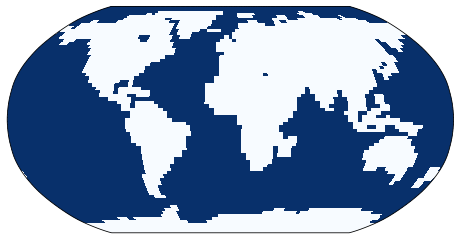

In [16]:
# Mask UKCA heights that are equal to zero
ukca_orog_masked = np.ma.masked_where(ukca_orog.data == 0., ukca_orog.data)
ukca_ocean_mask = ukca_orog_masked.mask # ocean is True
# Plot ocean mask
fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)))
ax.pcolormesh(ukca_lons, ukca_lats, ukca_ocean_mask, transform=ccrs.PlateCarree(), cmap='Blues');

In [17]:
ukca_meono2.data.min()

-4.596230964546153e-15

In [18]:
# Remove negative values and apply UKCA ocean mask
ukca_ocean_mask_brdcst = np.broadcast_to(ukca_ocean_mask, (12, 73, 96))
ukca_meono2_corrd = np.ma.masked_where((ukca_meono2.data<=0.) & ukca_ocean_mask_brdcst, ukca_meono2.data).filled(fill_value=0.)
ukca_etono2_corrd = np.ma.masked_where((ukca_etono2.data<=0.) & ukca_ocean_mask_brdcst, ukca_etono2.data).filled(fill_value=0.)
ukca_nprono2_corrd = np.ma.masked_where((ukca_nprono2.data<=0.) & ukca_ocean_mask_brdcst, ukca_nprono2.data).filled(fill_value=0.)
ukca_iprono2_corrd = np.ma.masked_where((ukca_iprono2.data<=0.) & ukca_ocean_mask_brdcst, ukca_iprono2.data).filled(fill_value=0.)

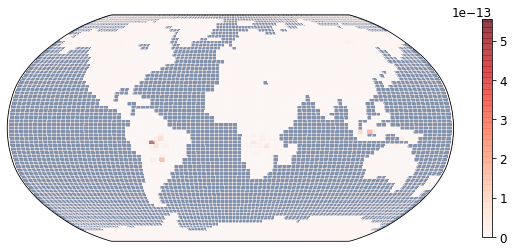

In [19]:
# Overlay UKCA land mask with emissions
fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)))
ax.pcolormesh(ukca_lons, ukca_lats, ukca_ocean_mask, transform=ccrs.PlateCarree(), cmap='Blues')
p1 = ax.pcolormesh(ukca_lons, ukca_lats, ukca_meono2_corrd[7,...], transform=ccrs.PlateCarree(), cmap='Reds', alpha=0.5);
fig.colorbar(p1, shrink=0.4);

Looks correct.

In [20]:
# Replace unmasked data in a cube with masked data
ukca_meono2.data = ukca_meono2_corrd
ukca_etono2.data = ukca_etono2_corrd
ukca_nprono2.data = ukca_nprono2_corrd
ukca_iprono2.data = ukca_iprono2_corrd

#### Calculate and compare burdens

In [21]:
gfed_cb_list = [gfed_meono2, gfed_etono2, gfed_nprono2, gfed_iprono2, gfed_grid_cell_area]
for cb in gfed_cb_list:
    for coord in ['latitude', 'longitude']:
        if not cb.coord(coord).has_bounds():
            cb.coord(coord).guess_bounds()
        if not cb.coord(coord).has_bounds():
            cb.coord(coord).guess_bounds()
    cb.coord('latitude').units = 'degrees'
    cb.coord('longitude').units = 'degrees'
def calc_burden_gfed(cb):
    # Calculate emission per grid cell per year
    cb_per_yr = cb.collapsed('time', iris.analysis.SUM)
    # Find area sum per year and multiply it by grid cell area
    cb_per_yr_area_sum = cb_per_yr*gfed_grid_cell_area
    # Calculate burden
    cb_burden = cb_per_yr_area_sum.collapsed(['latitude', 'longitude'], iris.analysis.SUM)
    cb_burden.convert_units('Gg/yr')
    return f'{cb_burden.data:1.2f}, Gg/yr;'

In [22]:
ukca_cb_list = [ukca_meono2, ukca_etono2, ukca_nprono2, ukca_iprono2]
for cb in ukca_cb_list:
    for coord in ['latitude', 'longitude']:
        if not cb.coord(coord).has_bounds():
            cb.coord(coord).guess_bounds()
        if not cb.coord(coord).has_bounds():
            cb.coord(coord).guess_bounds()
    cb.coord('latitude').units = 'degrees'
    cb.coord('longitude').units = 'degrees'
def calc_burden_ukca(cb):
    # Calculate emission per grid cell per year
    cb_per_yr = cb.collapsed('time', iris.analysis.SUM)
    # Calculate area weights and Earth's area
    area_weights_norm = iris.analysis.cartography.area_weights(cb_per_yr, normalize=True)
    area_weights_inm2 = iris.analysis.cartography.area_weights(cb_per_yr, normalize=False)
    earth_area = iris.cube.Cube(area_weights_inm2.sum(), units='m2')
    # Calculate burden: find area sum per year and multiply it by Earth's area
    cb_per_yr_area_sum = cb_per_yr.collapsed(['latitude', 'longitude'], iris.analysis.SUM, weights=area_weights_norm)
    cb_burden = cb_per_yr_area_sum*earth_area
    cb_burden.convert_units('Gg/yr')
    return f'{cb_burden.data:1.2f}, Gg/yr;', cb_burden.data

In [23]:
print(calc_burden_gfed(gfed_meono2), calc_burden_gfed(gfed_etono2), calc_burden_gfed(gfed_nprono2), calc_burden_gfed(gfed_iprono2))

/home/maria/miniconda3/lib/python3.7/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/home/maria/miniconda3/lib/python3.7/site-packages/iris/cube.py:3218: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/home/maria/miniconda3/lib/python3.7/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/home/maria/miniconda3/lib/python3.7/site-packages/iris/cube.py:3218: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/home/maria/miniconda3/lib/python3.7/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.forma

52.36, Gg/yr; 35.69, Gg/yr; 2.31, Gg/yr; 11.78, Gg/yr;


In [24]:
print(calc_burden_ukca(ukca_meono2)[0], calc_burden_ukca(ukca_etono2)[0], calc_burden_ukca(ukca_nprono2)[0], calc_burden_ukca(ukca_iprono2)[0])

53.69, Gg/yr; 36.60, Gg/yr; 2.36, Gg/yr; 11.89, Gg/yr;


/home/maria/miniconda3/lib/python3.7/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/home/maria/miniconda3/lib/python3.7/site-packages/iris/analysis/cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")
/home/maria/miniconda3/lib/python3.7/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/home/maria/miniconda3/lib/python3.7/site-packages/iris/analysis/cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")
/home/maria/miniconda3/lib/python3.7/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warni

In [25]:
# For converting RONO2 to N
molar_mass_n = iris.coords.AuxCoord(14.007, units='g/mol', long_name='molar_mass_of_atomic_nitrogen')
molar_mass_meono2 = iris.coords.AuxCoord(77.0394, units='g/mol', long_name='molar_mass_of_methyl_nitrate')
molar_mass_etono2 = iris.coords.AuxCoord(91.0660, units='g/mol', long_name='molar_mass_of_ethyl_nitrate')
molar_mass_prono2 = iris.coords.AuxCoord(105.0926, units='g/mol', long_name='molar_mass_of_propyl_nitrate')

In [26]:
# GFED in Gg N yr-1
print('GFED in Gg N yr-1')
print(' MeONO2:', 52.36/molar_mass_meono2.points[0]*molar_mass_n.points[0])
print(' EtONO2:', 35.69/molar_mass_etono2.points[0]*molar_mass_n.points[0])
print('nPrONO2:', 2.31/molar_mass_prono2.points[0]*molar_mass_n.points[0])
print('iPrONO2:', 11.78/molar_mass_prono2.points[0]*molar_mass_n.points[0])
print('  Total:', 52.36/molar_mass_meono2.points[0]*molar_mass_n.points[0]+35.69/molar_mass_etono2.points[0]*molar_mass_n.points[0]+
                  2.31/molar_mass_prono2.points[0]*molar_mass_n.points[0]+11.78/molar_mass_prono2.points[0]*molar_mass_n.points[0])

GFED in Gg N yr-1
 MeONO2: 9.51988878418056
 EtONO2: 5.4895331957042135
nPrONO2: 0.30788247697744653
iPrONO2: 1.5700673501274112
  Total: 16.88737180698963


In [27]:
# UKCA in Gg N yr-1
print('UKCA in Gg N yr-1')
print(' MeONO2:', 53.69/molar_mass_meono2.points[0]*molar_mass_n.points[0])
print(' EtONO2:', 36.60/molar_mass_etono2.points[0]*molar_mass_n.points[0])
print('nPrONO2:', 2.36/molar_mass_prono2.points[0]*molar_mass_n.points[0])
print('iPrONO2:', 11.89/molar_mass_prono2.points[0]*molar_mass_n.points[0])
print('  Total:', 53.69/molar_mass_meono2.points[0]*molar_mass_n.points[0]+36.60/molar_mass_etono2.points[0]*molar_mass_n.points[0]+
                  2.36/molar_mass_prono2.points[0]*molar_mass_n.points[0]+11.89/molar_mass_prono2.points[0]*molar_mass_n.points[0])

UKCA in Gg N yr-1
 MeONO2: 9.761704140997981
 EtONO2: 5.629501680100147
nPrONO2: 0.31454659985574623
iPrONO2: 1.5847284204596708
  Total: 17.290480841413547


In [28]:
print(9.52+5.49+0.31+1.57)
print(9.76+5.63+0.31+1.59) # 0.01?

16.89
17.290000000000003


In [29]:
print('% difference between GFEDs and UKCA')
print(' MeONO2:', 9.76*100/9.52)
print(' EtONO2:', 5.63*100/5.49)
print('iPrONO2:', 1.59*100/1.57)

% difference between GFEDs and UKCA
 MeONO2: 102.52100840336135
 EtONO2: 102.55009107468123
iPrONO2: 101.27388535031847


In [30]:
# Differences between GFED and UKCA burdens due to regridding [%]
-100+53.69*100/52.36, -100+36.60*100/35.69, -100+2.36*100/2.31, -100+11.89*100/11.78

(2.540106951871664, 2.549733818996927, 2.164502164502167, 0.9337860780984784)

In [31]:
# rono2_burden_ukca = calc_burden_ukca(ukca_meono2)[1]+calc_burden_ukca(ukca_etono2)[1]+calc_burden_ukca(ukca_nprono2)[1]+calc_burden_ukca(ukca_iprono2)[1]
# print(f'{rono2_burden_ukca:1.2f}, Gg/yr')

From Simpson et al. (2002):

'...global savanna burning emissions for the five C1–C4 alkyl nitrates reported here are estimated to total roughly 6.6 Gg/yr (mainly as MeONO2) during the flaming stage, and 1.2 Gg/yr (mainly as C2–C4 alkyl nitrates) during the smoldering stage, for a total on the order of 8 Gg/yr (Table 3). For global biomass burning, summed C1–C4 alkyl nitrate emissions on the order of 18 Gg/yr are estimated. In both cases, MeONO2 emissions during the flaming stage comprise a majority (roughly two-thirds) of the total C1–C4 alkyl nitrate emissions'.

?So, GFED/UKCA C1-C3 RONO2 biomass burning emissions are 5 times higher than Simpson et al. estimate.

#### Create perpetual year emissions

In [32]:
# Repeat emissions data 10 times along time axis
perpetual_meono2_arr = np.moveaxis(np.tile(np.moveaxis(ukca_meono2.data, 0, -1), 10), -1, 0)
perpetual_etono2_arr = np.moveaxis(np.tile(np.moveaxis(ukca_etono2.data, 0, -1), 10), -1, 0)
perpetual_nprono2_arr = np.moveaxis(np.tile(np.moveaxis(ukca_nprono2.data, 0, -1), 10), -1, 0)
perpetual_iprono2_arr = np.moveaxis(np.tile(np.moveaxis(ukca_iprono2.data, 0, -1), 10), -1, 0)
# Create a new time dimention or copy ukca.coord('time') if shapes are the same
if perpetual_meono2_arr.shape == ukca.coord('time').shape:
    time = ukca.coord('time')
else:
    start_date = ukca.coord('time').points[0]
    hours_since_start_date = np.arange(start_date, start_date+10*12*30*24, 720) # montly intervals in hours using 360 day calendar
    time = iris.coords.DimCoord(hours_since_start_date, standard_name='time', var_name='time', units=ukca.coord('time').units)

In [33]:
# Create iris cubes
perpetual_meono2_cb = iris.cube.Cube(perpetual_meono2_arr, long_name='methyl_nitrate_biomass_burning_emission', units='kg/m2/s',
                                     dim_coords_and_dims=[(time, 0), (ukca.coord('latitude'), 1), (ukca.coord('longitude'), 2)])
perpetual_etono2_cb = iris.cube.Cube(perpetual_etono2_arr, long_name='ethyl_nitrate_biomass_burning_emission', units='kg/m2/s',
                                     dim_coords_and_dims=[(time, 0), (ukca.coord('latitude'), 1), (ukca.coord('longitude'), 2)])
perpetual_nprono2_cb = iris.cube.Cube(perpetual_nprono2_arr, long_name='npropyl_nitrate_biomass_burning_emission', units='kg/m2/s',
                                      dim_coords_and_dims=[(time, 0), (ukca.coord('latitude'), 1), (ukca.coord('longitude'), 2)])
perpetual_iprono2_cb = iris.cube.Cube(perpetual_iprono2_arr, long_name='ipropyl_nitrate_biomass_burning_emission', units='kg/m2/s',
                                      dim_coords_and_dims=[(time, 0), (ukca.coord('latitude'), 1), (ukca.coord('longitude'), 2)])

In [34]:
# # Save iris cubes to .nc
# iris.save(perpetual_meono2_cb, str(path_to_ukca / 'perpetual_meono2_biomass_burning_emissions.nc'))
# iris.save(perpetual_etono2_cb, str(path_to_ukca / 'perpetual_etono2_biomass_burning_emissions.nc'))
# iris.save(perpetual_nprono2_cb, str(path_to_ukca / 'perpetual_nprono2_biomass_burning_emissions.nc'))
# iris.save(perpetual_iprono2_cb, str(path_to_ukca / 'perpetual_iprono2_biomass_burning_emissions.nc'))

#### Plot figures

In [35]:
# def plt_dm_map(lons, lats, cb, specie_latex, specie_str, source):
#     fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)))
#     p0 = ax.pcolormesh(lons, lats, cb, transform=ccrs.PlateCarree(), cmap='Reds')
#     ax.coastlines(color='grey', alpha=0.2)
#     ax.set_title(f'{source.upper()}\n{specie_latex} emissions')
#     fig.colorbar(p0, shrink=0.4, label='Dry matter, kg $m^{-2}$ $yr^{-1}$')
#     fig.savefig(path_to_figs / f'{source}_dm_{specie_str}_biomass_burning_emissions_per_yr.png', bbox_inches='tight')
    
# # plt_dm_map(gfed_lons, gfed_lats, dm_borf.collapsed('time', iris.analysis.SUM).data, 'Boreal forest fire', 'borf', 'gfed')
# # plt_dm_map(gfed_lons, gfed_lats, dm_temf.collapsed('time', iris.analysis.SUM).data, 'Temperate forest fire', 'temf', 'gfed')
# # plt_dm_map(gfed_lons, gfed_lats, dm_trof.collapsed('time', iris.analysis.SUM).data, 'Tropical forest fire', 'trof', 'gfed')
# # plt_dm_map(gfed_lons, gfed_lats, dm_sava.collapsed('time', iris.analysis.SUM).data, 'Savanna, grassland and shrubland fire', 'sava', 'gfed')
# # plt_dm_map(gfed_lons, gfed_lats, (dm_borf+dm_temf+dm_trof+dm_sava).collapsed('time', iris.analysis.SUM).data, 
# #            'This study sum of biomass burning', 'all', 'gfed')

In [36]:
lats = ukca.coord('latitude').points

In [37]:
# Select the first 12 months
meono2 = perpetual_meono2_cb[0:12,...]
etono2 = perpetual_etono2_cb[0:12,...]
nprono2 = perpetual_nprono2_cb[0:12,...]
iprono2 = perpetual_iprono2_cb[0:12,...]
# Add a season coordinate
iris.coord_categorisation.add_season(meono2, 'time', name='season')
iris.coord_categorisation.add_season(etono2, 'time', name='season')
iris.coord_categorisation.add_season(nprono2, 'time', name='season')
iris.coord_categorisation.add_season(iprono2, 'time', name='season')

In [38]:
# Annual sum
meono2_ann, lons = cartopy.util.add_cyclic_point(meono2.collapsed('time', iris.analysis.SUM).data, coord=meono2.coord('longitude').points)
etono2_ann = cartopy.util.add_cyclic_point(etono2.collapsed('time', iris.analysis.SUM).data)
nprono2_ann = cartopy.util.add_cyclic_point(nprono2.collapsed('time', iris.analysis.SUM).data)
iprono2_ann = cartopy.util.add_cyclic_point(iprono2.collapsed('time', iris.analysis.SUM).data)
# Mask zero emissions
mskd_meono2_ann = np.ma.masked_where(meono2_ann.data<=0.00000000e+00, meono2_ann.data)
mskd_etono2_ann = np.ma.masked_where(etono2_ann.data<=0.00000000e+00, etono2_ann.data)
mskd_nprono2_ann = np.ma.masked_where(nprono2_ann.data<=0.00000000e+00, nprono2_ann.data)
mskd_iprono2_ann = np.ma.masked_where(iprono2_ann.data<=0.00000000e+00, iprono2_ann.data)
# Find max annual emission
ann_max = max(meono2_ann.max(), etono2_ann.max(), nprono2_ann.max(), iprono2_ann.max())

/home/maria/miniconda3/lib/python3.7/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/home/maria/miniconda3/lib/python3.7/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/home/maria/miniconda3/lib/python3.7/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/home/maria/miniconda3/lib/python3.7/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))


In [39]:
for_paper = True
for_thesis = False

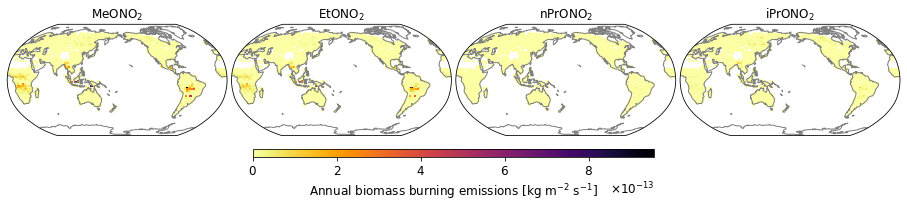

In [40]:
if for_paper:
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16,5), facecolor="w", subplot_kw=dict(projection=ccrs.Robinson(central_longitude=180)))
    # Hide zero emissions
    cmap_hide = copy(plt.cm.inferno_r)
    cmap_hide.set_bad('w', 0)
    p00 = ax[0].pcolormesh(lons, lats, mskd_meono2_ann, transform=ccrs.PlateCarree(), vmin=0, vmax=ann_max, cmap=cmap_hide);
    ax[1].pcolormesh(lons, lats, mskd_etono2_ann, transform=ccrs.PlateCarree(), vmin=0, vmax=ann_max, cmap=cmap_hide);
    ax[2].pcolormesh(lons, lats, mskd_nprono2_ann, transform=ccrs.PlateCarree(), vmin=0, vmax=ann_max, cmap=cmap_hide);
    ax[3].pcolormesh(lons, lats, mskd_iprono2_ann, transform=ccrs.PlateCarree(), vmin=0, vmax=ann_max, cmap=cmap_hide);
    # common
    ax[0].set_title(f'$MeONO_2$')
    ax[1].set_title(f'$EtONO_2$')
    ax[2].set_title(f'$nPrONO_2$')
    ax[3].set_title(f'$iPrONO_2$')
    for iax in ax.flatten(): iax.coastlines(color='grey')
    fig.subplots_adjust(wspace=0.02) #hspace=-0.58
    cb00_fmt = ticker.ScalarFormatter(useMathText=True)
    cb00_fmt.set_powerlimits((0, 0))
    cb00 = fig.colorbar(p00, ax=ax, orientation='horizontal', label="Annual biomass burning emissions [kg $m^{-2}$ $s^{-1}$]", format=cb00_fmt, shrink=0.45, pad=0.05, aspect=50)
#     fig.savefig(path_to_figs / f'rono2_bb_emis_ann_config_row.png', bbox_inches='tight', dpi=300)

In [41]:
if for_thesis:
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,12), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=180)))
    # Hide zero emissions
    cmap_hide = copy(plt.cm.inferno_r)
    cmap_hide.set_bad('w', 0)
    p00 = ax[0,0].pcolormesh(lons, lats, mskd_meono2_ann, transform=ccrs.PlateCarree(), vmin=0, vmax=ann_max, cmap=cmap_hide);
    ax[0,1].pcolormesh(lons, lats, mskd_etono2_ann, transform=ccrs.PlateCarree(), vmin=0, vmax=ann_max, cmap=cmap_hide);
    ax[1,0].pcolormesh(lons, lats, mskd_nprono2_ann, transform=ccrs.PlateCarree(), vmin=0, vmax=ann_max, cmap=cmap_hide);
    ax[1,1].pcolormesh(lons, lats, mskd_iprono2_ann, transform=ccrs.PlateCarree(), vmin=0, vmax=ann_max, cmap=cmap_hide);
    # common
    ax[0,0].set_title(f'$MeONO_2$')
    ax[0,1].set_title(f'$EtONO_2$')
    ax[1,0].set_title(f'$nPrONO_2$')
    ax[1,1].set_title(f'$iPrONO_2$')
    for iax in ax.flatten(): iax.coastlines(color='grey') 
    cax = fig.add_axes([0.925, 0.35, 0.009, 0.31])
    cb00 = fig.colorbar(p00, cax=cax, orientation='vertical')
    cb00.ax.set_title('kg $m^{-2}$ $s^{-1}$  ', pad=15);
    fig.suptitle('Biomass burning emissions: annual sum', x=0.3, y=0.76)#, weight='bold')
    fig.subplots_adjust(hspace=-0.58, wspace=0.02)
    fig.savefig(path_to_figs / f'rono2_bb_emis_ann.png', bbox_inches='tight', dpi=300)

In [42]:
break

SyntaxError: 'break' outside loop (<ipython-input-42-6aaf1f276005>, line 4)

In [ ]:
# Seasonal sum
meono2_ssn = cartopy.util.add_cyclic_point(meono2.aggregated_by(['season'], iris.analysis.SUM).data)
etono2_ssn = cartopy.util.add_cyclic_point(etono2.aggregated_by(['season'], iris.analysis.SUM).data)
nprono2_ssn = cartopy.util.add_cyclic_point(nprono2.aggregated_by(['season'], iris.analysis.SUM).data)
iprono2_ssn = cartopy.util.add_cyclic_point(iprono2.aggregated_by(['season'], iris.analysis.SUM).data)
# Mask zero emissions
mskd_meono2_ssn = np.ma.masked_where(meono2_ssn.data<=0.00000000e+00, meono2_ssn.data)
mskd_etono2_ssn = np.ma.masked_where(etono2_ssn.data<=0.00000000e+00, etono2_ssn.data)
mskd_nprono2_ssn = np.ma.masked_where(nprono2_ssn.data<=0.00000000e+00, nprono2_ssn.data)
mskd_iprono2_ssn = np.ma.masked_where(iprono2_ssn.data<=0.00000000e+00, iprono2_ssn.data)
# Find max ssnual emission
ssn_max = max(meono2_ssn.max(), etono2_ssn.max(), nprono2_ssn.max(), iprono2_ssn.max())

In [ ]:
for issn, ssn in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,12), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)))
    # Hide zero emissions
    cmap_hide = copy(plt.cm.inferno_r)
    cmap_hide.set_bad('w', 0)
    p00 = ax[0,0].pcolormesh(lons, lats, mskd_meono2_ssn[issn,...], transform=ccrs.PlateCarree(), vmin=0, vmax=ssn_max, cmap=cmap_hide);
    ax[0,1].pcolormesh(lons, lats, mskd_etono2_ssn[issn,...], transform=ccrs.PlateCarree(), vmin=0, vmax=ssn_max, cmap=cmap_hide);
    ax[1,0].pcolormesh(lons, lats, mskd_nprono2_ssn[issn,...], transform=ccrs.PlateCarree(), vmin=0, vmax=ssn_max, cmap=cmap_hide);
    ax[1,1].pcolormesh(lons, lats, mskd_iprono2_ssn[issn,...], transform=ccrs.PlateCarree(), vmin=0, vmax=ssn_max, cmap=cmap_hide);
    # common
    ax[0,0].set_title('$MeONO_2$')
    ax[0,1].set_title('$EtONO_2$')
    ax[1,0].set_title('$nPrONO_2$')
    ax[1,1].set_title('$iPrONO_2$')
    for iax in ax.flatten(): iax.coastlines(color='grey') 
    cax = fig.add_axes([0.923, 0.35, 0.009, 0.31])
    cb00 = fig.colorbar(p00, cax=cax, orientation='vertical')
    cb00.ax.set_title('kg $m^{-2}$ $s^{-1}$  ', pad=15);
    fig.suptitle(f'Biomass burning emissions: {ssn}', x=0.26, y=0.76)#, weight='bold')
    fig.subplots_adjust(hspace=-0.58, wspace=0.02)
    fig.savefig(path_to_figs / f'rono2_bb_emis_ssn_{issn+1}.png', bbox_inches='tight', dpi=300)

In [ ]:
# Monthly
meono2_mon = cartopy.util.add_cyclic_point(meono2.data)
etono2_mon = cartopy.util.add_cyclic_point(etono2.data)
nprono2_mon = cartopy.util.add_cyclic_point(nprono2.data)
iprono2_mon = cartopy.util.add_cyclic_point(iprono2.data)
# Mask zero emissions
mskd_meono2_mon = np.ma.masked_where(meono2_mon.data<=0.00000000e+00, meono2_mon.data)
mskd_etono2_mon = np.ma.masked_where(etono2_mon.data<=0.00000000e+00, etono2_mon.data)
mskd_nprono2_mon = np.ma.masked_where(nprono2_mon.data<=0.00000000e+00, nprono2_mon.data)
mskd_iprono2_mon = np.ma.masked_where(iprono2_mon.data<=0.00000000e+00, iprono2_mon.data)
# Find max monthly emission
mon_max = max(meono2_mon.max(), etono2_mon.max(), nprono2_mon.max(), iprono2_mon.max())

In [ ]:
for imn, mn in enumerate([calendar.month_abbr[i] for i in range(13)][1:]):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,12), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)))
    # Hide zero emissions
    cmap_hide = copy(plt.cm.inferno_r)
    cmap_hide.set_bad('w', 0)
    p00 = ax[0,0].pcolormesh(lons, lats, mskd_meono2_mon[imn,...], transform=ccrs.PlateCarree(), vmin=0, vmax=mon_max, cmap=cmap_hide);
    ax[0,1].pcolormesh(lons, lats, mskd_etono2_mon[imn,...], transform=ccrs.PlateCarree(), vmin=0, vmax=mon_max, cmap=cmap_hide);
    ax[1,0].pcolormesh(lons, lats, mskd_nprono2_mon[imn,...], transform=ccrs.PlateCarree(), vmin=0, vmax=mon_max, cmap=cmap_hide);
    ax[1,1].pcolormesh(lons, lats, mskd_iprono2_mon[imn,...], transform=ccrs.PlateCarree(), vmin=0, vmax=mon_max, cmap=cmap_hide);
    # common
    ax[0,0].set_title(f'$MeONO_2$')
    ax[0,1].set_title(f'$EtONO_2$')
    ax[1,0].set_title(f'$nPrONO_2$')
    ax[1,1].set_title(f'$iPrONO_2$')
    for iax in ax.flatten(): iax.coastlines(color='grey') 
    cax = fig.add_axes([0.923, 0.35, 0.009, 0.31])
    cb00 = fig.colorbar(p00, cax=cax, orientation='vertical')
    cb00.ax.set_title('kg $m^{-2}$ $s^{-1}$  ', pad=15);
    fig.suptitle(f'Biomass burning emissions: {mn}', x=0.26, y=0.76)#, weight='bold')
    fig.subplots_adjust(hspace=-0.58, wspace=0.02)
    fig.savefig(path_to_figs / f'rono2_bb_emis_mon_{imn+1}.png', bbox_inches='tight', dpi=300)

In [ ]:
# def plt_rono2_map(lons, lats, cb, specie_latex, specie_str, source):
#     fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)))
#     p0 = ax.pcolormesh(lons, lats, cb, transform=ccrs.PlateCarree(), cmap='Reds')
#     ax.coastlines(color='grey', alpha=0.2)
#     ax.set_title(f'{source.upper()}\n{specie_latex} biomass burning emissions')
#     fig.colorbar(p0, shrink=0.4, label='kg $m^{-2}$ $yr^{-1}$')
# #     fig.savefig(path_to_figs / f'{source}_rono2_{specie_str}_biomass_burning_emissions_per_yr.png', bbox_inches='tight')
    
# # Plot at GFEDs resolution
# # plt_rono2_map(gfed_lons, gfed_lats, gfed_meono2.collapsed('time', iris.analysis.SUM).data, '$MeONO_2$', 'c1', 'gfed')
# # plt_rono2_map(gfed_lons, gfed_lats, gfed_etono2.collapsed('time', iris.analysis.SUM).data, '$EtONO_2$', 'c2', 'gfed')
# # plt_rono2_map(gfed_lons, gfed_lats, gfed_nprono2.collapsed('time', iris.analysis.SUM).data, '$nPrONO_2$', 'c3n', 'gfed')
# # plt_rono2_map(gfed_lons, gfed_lats, gfed_iprono2.collapsed('time', iris.analysis.SUM).data, '$iPrONO_2$', 'c3i', 'gfed')